<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Импорт данных

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
try:
    data_raw = pd.read_csv('toxic_comments.csv')
except:
    data_raw = pd.read_csv('/datasets/toxic_comments.csv')
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [3]:
data_raw.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data_raw = data_raw.drop(['Unnamed: 0'], axis=1)

In [6]:
data_raw['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

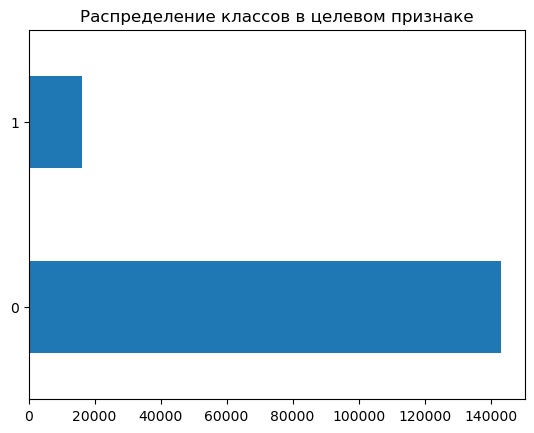

In [9]:
data['toxic'].value_counts().plot(kind='barh')
plt.title('Распределение классов в целевом признаке')
plt.show()

## Готовим признаки

### Лемматизация текста

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexandrplakhotin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alexandrplakhotin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
def clean_and_lem(text):
    txt = text.lower()
    txt = re.sub('[^a-z]', ' ', txt)
    txt = re.sub(r'\b\w{1,2}\b', ' ', txt)
    txt = txt.split()
    lem = WordNetLemmatizer()
    txt = [lem.lemmatize(word) for word in txt]
    txt = ' '.join(txt)
    return txt

In [12]:
data = data_raw.copy()
data['text'] = data['text'].apply(clean_and_lem)

In [13]:
print(data['text'][0])
print('---')
print(data_raw['text'][0])

explanation why the edits made under username hardcore metallica fan were reverted they weren vandalism just closure some gas after voted new york doll fac and please don remove the template from the talk page since retired now
---
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [14]:
train, test = train_test_split(data, test_size=0.2, stratify=data['toxic'])
print(train.shape, test.shape)

(127433, 2) (31859, 2)


In [15]:
toxic0 = train.query('toxic == 0')
toxic1 = train.query('toxic == 1')
toxic1 = pd.DataFrame(np.repeat(toxic1.values, 8, axis=0))
toxic1.columns = data.columns

train_ups = (pd.concat([toxic0, toxic1])
         .sample(frac = 1, random_state=123)
         .reset_index(drop=True))
train_ups['toxic'].value_counts()

0    114484
1    103592
Name: toxic, dtype: int64

In [28]:
train_ups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218076 entries, 0 to 218075
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    218076 non-null  object
 1   toxic   218076 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


In [29]:
train_ups['toxic'] = train_ups['toxic'].astype(int)

### TF-IDF

In [30]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 
count_tf_idf.fit(train_ups['text'])

X_train = count_tf_idf.transform(train_ups['text'])
X_test = count_tf_idf.transform(test['text'])

y_train = train_ups['toxic']
y_test = test['toxic']

## Обучение

In [33]:
model = LogisticRegression(max_iter=1000, C=10)
cv = cross_val_score(model, X_train, y_train, scoring='f1', n_jobs=4)
print(*cv)
print(cv.mean())

0.9753060011883542 0.9771290000475489 0.9750243115675624 0.9764831767922958 0.9783250762195121
0.9764535131630547


In [34]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.7656021095810137

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны